In [1]:
import networkx as nx
import pm4py as pm
from pm4py.algo.analysis.woflan import algorithm as woflan
from matplotlib import pyplot
from itertools import combinations

In [2]:
# %matplotlib widget

In [3]:
!python -V

Python 3.10.10


In [4]:
nx.__version__

'3.0'

In [5]:
pm.__version__

'2.7.2'

In [6]:
# Transition type
Transition_t = pm.objects.petri_net.obj.PetriNet.Transition

In [7]:
def is_free_choice(transitions: set[Transition_t]):
    """Brute force algorithm to check whether the net is free choice or not"""
    for comb in combinations(transitions, 2):
        t1, t2 = comb
        t1_preset = {arc.source for arc in t1.in_arcs}
        t2_preset = {arc.source for arc in t2.in_arcs}
        if not t1_preset.isdisjoint(t2_preset) and not t1_preset == t2_preset:
            return False
    return True

def free_choice_violations(transitions: set[Transition_t]):
    """Brute force algorithm to retrive non free choice transitions"""
    res = []
    for comb in combinations(transitions, 2):
        t1, t2 = comb
        t1_preset = {arc.source for arc in t1.in_arcs}
        t2_preset = {arc.source for arc in t2.in_arcs}
        if not t1_preset.isdisjoint(t2_preset) and not t1_preset == t2_preset:
            res.append(comb)
    return res

In [8]:
from pm4py.algo.analysis.woflan.not_well_handled_pairs\
    .not_well_handled_pairs import create_network_graph

def not_well_handled_pairs(net):
    """This is the "apply" function modified in order to return pairs of nodes 
    instead of pairs of indexes (see pm4py\\algo\\analysis\\woflan\\
    not_well_handled_pairs\\not_well_handled_pairs)"""
    graph, booking = create_network_graph(net)
    pairs = []
    for place in net.places:
        p = booking[place]
        for transition in net.transitions:
            t = booking[transition]
            if nx.maximum_flow_value(graph, p+1, t) > 1:
                pairs.append((place, transition))
            if nx.maximum_flow_value(graph, t+1, p) > 1:
                pairs.append((transition, place))
    return pairs

# System

In [9]:
path = r"..\workflow nets\wf_system.pnml"

In [10]:
net, ip, fp = pm.read.read_pnml(path, True)

In [12]:
pm.check_is_workflow_net(net)

True

Since the net is a WF net, the short-circuited net is strongly connected.

In [13]:
len(net.transitions), len(net.places), len(net.arcs)

(129, 135, 318)

In [13]:
is_free_choice(net.transitions)

False

In [10]:
free_choice_violations(net.transitions)

[((t98, 'collab confermed'), (t96, 'collab denied')),
 ((t40, 'Draft accepted'), (t34, 'changes recived')),
 ((t40, 'Draft accepted'), (t39, 'Draft rejected')),
 ((t70, 'draft rejected'), (t65, 'changes recived')),
 ((t70, 'draft rejected'), (t73, 'Draft accepted')),
 ((t79, 'prop wothdrawn'), (t82, 'req confermed')),
 ((t106, 'new draft recived'), (t18, 'Final outcome')),
 ((t86, 'to be fixed'), (t83, 'rejection accepted')),
 ((t23, 'chenges rejected'), (t25, 'new draft recived')),
 ((t94, 'app submitted'), (t92, 'proc cancelled')),
 ((t105, 'collab denied'), (t45, 'app rejected')),
 ((t105, 'collab denied'), (t44, 'app accepted')),
 ((t65, 'changes recived'), (t73, 'Draft accepted')),
 ((t88, 'req withdrawn'), (t87, 'App revised recived')),
 ((t34, 'changes recived'), (t39, 'Draft rejected')),
 ((t45, 'app rejected'), (t44, 'app accepted')),
 ((t56, 'collab refused'), (t59, 'collab accepted'))]

Every time we use en event based gateway we introduce at least one free choice violation. Particularly, for every event based gateway, the number of violations are $n \choose{2}$, where $n$ is the number of external events that may occur at the gateway.

In [14]:
pt_tp = not_well_handled_pairs(net)

In [15]:
len(pt_tp)

257

In [16]:
pt_tp

[((t100, 'start'), p23),
 ((t95, 'ask for conf'), p23),
 ((t9, 'approve draft'), p23),
 ((t55, 'ask for collab'), p23),
 ((t5, 'accept collab'), p23),
 ((t43, 'submit app'), p23),
 ((t54, 'instantiate proc'), p23),
 ((t10, 'modify draft'), p23),
 ((t37, 'propose new draft'), p23),
 (p49, (t18, 'Final outcome')),
 (p49, (t103, 'end')),
 (p49, (t83, 'rejection accepted')),
 ((t100, 'start'), p74),
 ((t21, 'modify draft'), p74),
 ((t95, 'ask for conf'), p74),
 ((t9, 'approve draft'), p74),
 ((t55, 'ask for collab'), p74),
 ((t5, 'accept collab'), p74),
 ((t14, 'confirm collab'), p74),
 ((t43, 'submit app'), p74),
 ((t54, 'instantiate proc'), p74),
 ((t66, 'propose new draft'), p74),
 ((t10, 'modify draft'), p74),
 ((t19, 'approve draft'), p74),
 ((t26, 'Reject draft'), p74),
 ((t37, 'propose new draft'), p74),
 ((t100, 'start'), p6),
 ((t55, 'ask for collab'), p6),
 ((t5, 'accept collab'), p6),
 (p100, (t103, 'end')),
 (p100, (t105, 'collab denied')),
 ((t100, 'start'), p79),
 ((t21, 'mod

In all the PT and TP handels is involved an event based gateway (The XOR split place or the XOR join between different branches of an event based gateway)

In [14]:
res = pm.analysis.check_soundness(net, ip, fp)

Input is ok.
Petri Net is a workflow net.
Every place is covered by s-components.
There are no dead tasks.
All tasks are live.


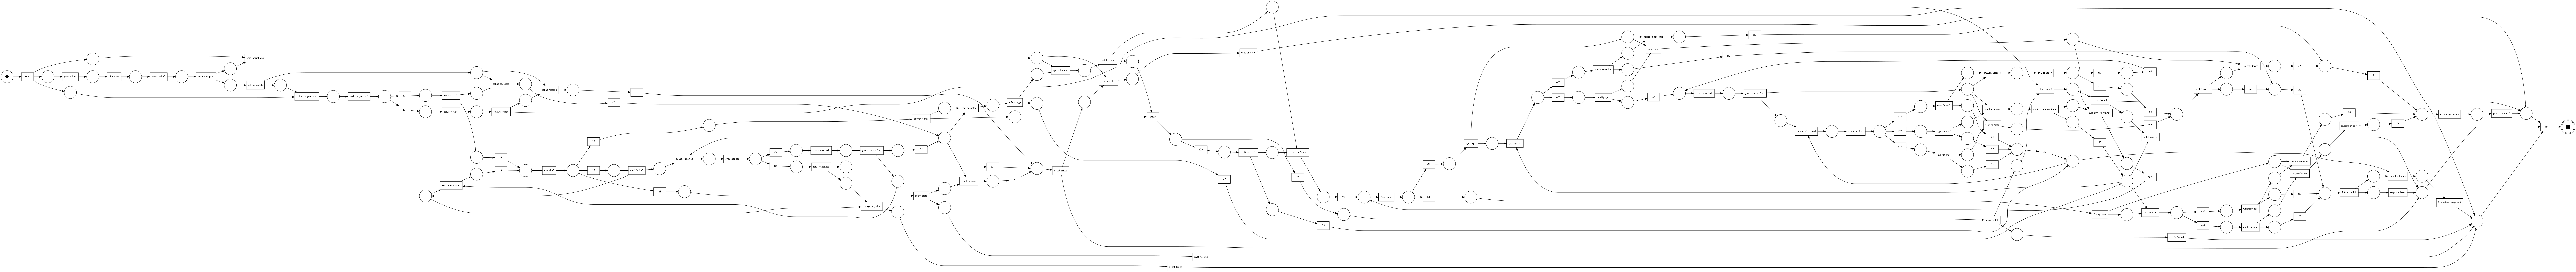

In [7]:
pm.view_petri_net(net, ip, fp)

In [46]:
pm.save_vis_petri_net(net, ip, fp, "pm_petri.svg")

In [48]:
bpmn_diag = pm.convert_to_bpmn(net, ip, fp)

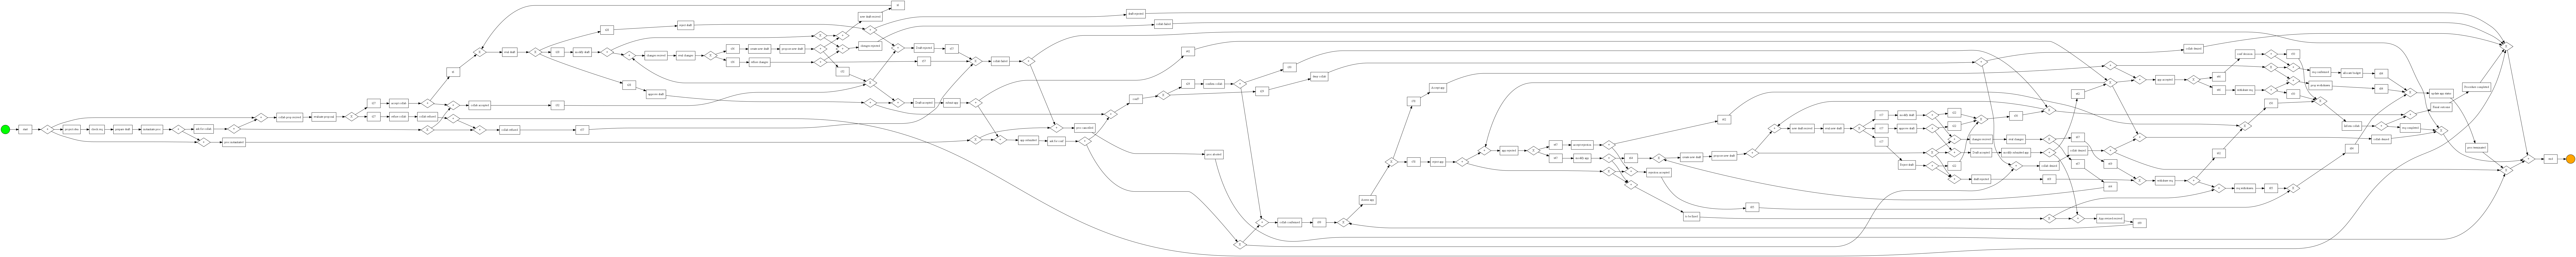

In [53]:
pm.view_bpmn(bpmn_diag)

In [13]:
pm.solve_marking_equation(net, ip, fp)

18

In [18]:
minimal_cov_graph = woflan.minimal_coverability_graph(net, ip)
woflan.check_for_dead_tasks(net, minimal_cov_graph)

[]

In [19]:
place_invariants = woflan.compute_place_invariants(net)

In [20]:
len(place_invariants)

17

In [21]:
place_invariants

array([[[ 0.],
        [ 0.],
        [ 0.],
        ...,
        [ 0.],
        [ 0.],
        [ 0.]],

       [[ 0.],
        [ 0.],
        [ 0.],
        ...,
        [ 0.],
        [ 0.],
        [ 0.]],

       [[ 0.],
        [ 0.],
        [ 0.],
        ...,
        [ 0.],
        [ 0.],
        [ 0.]],

       ...,

       [[-1.],
        [ 0.],
        [ 0.],
        ...,
        [ 1.],
        [ 0.],
        [ 0.]],

       [[ 0.],
        [ 0.],
        [ 0.],
        ...,
        [ 0.],
        [ 1.],
        [ 0.]],

       [[ 0.],
        [ 1.],
        [ 0.],
        ...,
        [ 0.],
        [ 0.],
        [ 1.]]])

In [22]:
for arr in place_invariants:
    print(all(arr >= 0), len(arr))

False 135
False 135
False 135
False 135
False 135
False 135
False 135
False 135
False 135
False 135
False 135
False 135
False 135
False 135
False 135
False 135
False 135


In [122]:
woflan.compute_s_components(net, place_invariants)

[{(t100, 'start'),
  (t103, 'end'),
  (t76, 'Assess app'),
  (t77, 'Accept app'),
  (t78_op_1, 't78'),
  (t78_op_2, 't78'),
  (t79, 'prop wothdrawn'),
  (t80, 'reject app'),
  (t81, 'allocate budget'),
  (t82, 'req confermed'),
  (t83, 'rejection accepted'),
  (t84_op_1, 't84'),
  (t84_op_2, 't84'),
  (t84_op_3, 't84'),
  (t85_op_1, 't85'),
  (t85_op_2, 't85'),
  (t86, 'to be fixed'),
  (t87, 'App revised recived'),
  (t88, 'req withdrawn'),
  (t89, 'proc terminated'),
  (t90, 'update app status'),
  (t91, 'proc instantiated'),
  (t92, 'proc cancelled'),
  (t93, 'proc aborted'),
  (t94, 'app submitted'),
  (t95, 'ask for conf'),
  (t96, 'collab denied'),
  (t97, 'collab denied'),
  (t98, 'collab confermed'),
  (t99_op_1, 't99'),
  (t99_op_2, 't99'),
  p100,
  p101,
  p102,
  p103,
  p104,
  p105,
  p116,
  p81,
  p82,
  p83,
  p84,
  p85,
  p86,
  p87,
  p88,
  p89,
  p90,
  p91,
  p92,
  p93,
  p94,
  p95,
  p96,
  p97,
  p98,
  p99}]

In [123]:
woflan.compute_uncovered_place_in_invariants(place_invariants, net)

[]

In [ ]:
woflan.compute_uncovered_places_in_component()

# Collaborators

In [19]:
path = r"..\workflow nets\collaborators.pnml"

In [20]:
net, ip, fp = pm.read.read_pnml(path, True)

In [52]:
# net with reset transitions

net_reset, _ = woflan.short_circuit_petri_net(net)

In [46]:
net.transitions

{(t1, 'collab prop recived'),
 (t10, 'modify draft'),
 (t11, 'draft rejected'),
 (t12, 'conf?'),
 (t13, 'deny collab'),
 (t14, 'confirm collab'),
 (t15, 'collab denied'),
 (t16, 'eval new draft'),
 (t17_op_1, 't17'),
 (t17_op_2, 't17'),
 (t17_op_3, 't17'),
 (t18, 'Finial outcome'),
 (t19, 'approve draft'),
 (t2, 'evaluate proposal'),
 (t20, 'Procedure completed'),
 (t21, 'modify draft'),
 (t22_op_1, 't22'),
 (t22_op_2, 't22'),
 (t22_op_3, 't22'),
 (t23, 'chenges rejected'),
 (t24, 'collab failed'),
 (t25, 'new draft recived'),
 (t26, 'Reject draft'),
 (t27_op_1, 't27'),
 (t27_op_2, 't27'),
 (t28_op_1, 't28'),
 (t28_op_2, 't28'),
 (t28_op_3, 't28'),
 (t29_op_1, 't29'),
 (t29_op_2, 't29'),
 (t3, 'refuse collab'),
 (t30_op_1, 't30'),
 (t30_op_2, 't30'),
 (t33, 'new draft recived'),
 (t4, 'collab refused'),
 (t5, 'accept collab'),
 (t6_op_1, 't6'),
 (t6_op_2, 't6'),
 (t7, 'eval draft'),
 (t8, 'reject draft'),
 (t9, 'approve draft')}

In [53]:
net_reset.transitions

{(short_circuited_transition, 'short_circuited_transition'),
 (t1, 'collab prop recived'),
 (t10, 'modify draft'),
 (t11, 'draft rejected'),
 (t12, 'conf?'),
 (t13, 'deny collab'),
 (t14, 'confirm collab'),
 (t15, 'collab denied'),
 (t16, 'eval new draft'),
 (t17_op_1, 't17'),
 (t17_op_2, 't17'),
 (t17_op_3, 't17'),
 (t18, 'Finial outcome'),
 (t19, 'approve draft'),
 (t2, 'evaluate proposal'),
 (t20, 'Procedure completed'),
 (t21, 'modify draft'),
 (t22_op_1, 't22'),
 (t22_op_2, 't22'),
 (t22_op_3, 't22'),
 (t23, 'chenges rejected'),
 (t24, 'collab failed'),
 (t25, 'new draft recived'),
 (t26, 'Reject draft'),
 (t27_op_1, 't27'),
 (t27_op_2, 't27'),
 (t28_op_1, 't28'),
 (t28_op_2, 't28'),
 (t28_op_3, 't28'),
 (t29_op_1, 't29'),
 (t29_op_2, 't29'),
 (t3, 'refuse collab'),
 (t30_op_1, 't30'),
 (t30_op_2, 't30'),
 (t33, 'new draft recived'),
 (t4, 'collab refused'),
 (t5, 'accept collab'),
 (t6_op_1, 't6'),
 (t6_op_2, 't6'),
 (t7, 'eval draft'),
 (t8, 'reject draft'),
 (t9, 'approve draft

In [19]:
pm.check_is_workflow_net(net)

True

In [54]:
pm.check_is_workflow_net(net_reset)

False

In [21]:
pm.analysis.check_soundness(net, ip, fp)

Input is ok.
Petri Net is a workflow net.
Every place is covered by s-components.
There are no dead tasks.
All tasks are live.


(True,
 {'s_c_net': places: [ p1, p10, p11, p12, p13, p14, p15, p16, p17, p18, p19, p2, p20, p21, p22, p23, p24, p25, p26, p27, p28, p29, p3, p30, p31, p32, p33, p34, p4, p5, p6, p7, p8, p9 ]
  transitions: [ (short_circuited_transition, 'short_circuited_transition'), (t1, 'collab prop recived'), (t10, 'modify draft'), (t11, 'draft rejected'), (t12, 'conf?'), (t13, 'deny collab'), (t14, 'confirm collab'), (t15, 'collab denied'), (t16, 'eval new draft'), (t17_op_1, 't17'), (t17_op_2, 't17'), (t17_op_3, 't17'), (t18, 'Final outcome'), (t19, 'approve draft'), (t2, 'evaluate proposal'), (t20, 'Procedure completed'), (t21, 'modify draft'), (t22_op_1, 't22'), (t22_op_2, 't22'), (t22_op_3, 't22'), (t23, 'chenges rejected'), (t24, 'collab failed'), (t25, 'new draft recived'), (t26, 'Reject draft'), (t27_op_1, 't27'), (t27_op_2, 't27'), (t28_op_1, 't28'), (t28_op_2, 't28'), (t28_op_3, 't28'), (t29_op_1, 't29'), (t29_op_2, 't29'), (t3, 'refuse collab'), (t30_op_1, 't30'), (t30_op_2, 't30'), (t33

In [8]:
pm.analysis.solve_marking_equation(net, ip, fp)

5

In [21]:
place_invariants = woflan.compute_place_invariants(net)

In [22]:
place_invariants

array([[[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]]])

In [24]:
woflan.compute_uncovered_place_in_invariants(place_invariants, net)

[]

In [26]:
s_components = woflan.compute_s_components(net, place_invariants)
s_components

[{(t1, 'collab prop recived'),
  (t10, 'modify draft'),
  (t11, 'draft rejected'),
  (t12, 'conf?'),
  (t13, 'deny collab'),
  (t14, 'confirm collab'),
  (t15, 'collab denied'),
  (t16, 'eval new draft'),
  (t17_op_1, 't17'),
  (t17_op_2, 't17'),
  (t17_op_3, 't17'),
  (t18, 'Finial outcome'),
  (t19, 'approve draft'),
  (t2, 'evaluate proposal'),
  (t20, 'Procedure completed'),
  (t21, 'modify draft'),
  (t22_op_1, 't22'),
  (t22_op_2, 't22'),
  (t22_op_3, 't22'),
  (t23, 'chenges rejected'),
  (t24, 'collab failed'),
  (t25, 'new draft recived'),
  (t26, 'Reject draft'),
  (t27_op_1, 't27'),
  (t27_op_2, 't27'),
  (t28_op_1, 't28'),
  (t28_op_2, 't28'),
  (t28_op_3, 't28'),
  (t29_op_1, 't29'),
  (t29_op_2, 't29'),
  (t3, 'refuse collab'),
  (t30_op_1, 't30'),
  (t30_op_2, 't30'),
  (t33, 'new draft recived'),
  (t4, 'collab refused'),
  (t5, 'accept collab'),
  (t6_op_1, 't6'),
  (t6_op_2, 't6'),
  (t7, 'eval draft'),
  (t8, 'reject draft'),
  (t9, 'approve draft'),
  p1,
  p10,
  p

In [27]:
woflan.compute_uncovered_places_in_component(s_components, net)

[]

In [28]:
woflan.compute_not_well_handled_pairs(net)

[]

In [29]:
woflan.compute_not_well_handled_pairs(net)

[]

In [30]:
rg = woflan.reachability_graph(net, ip)

In [31]:
rg

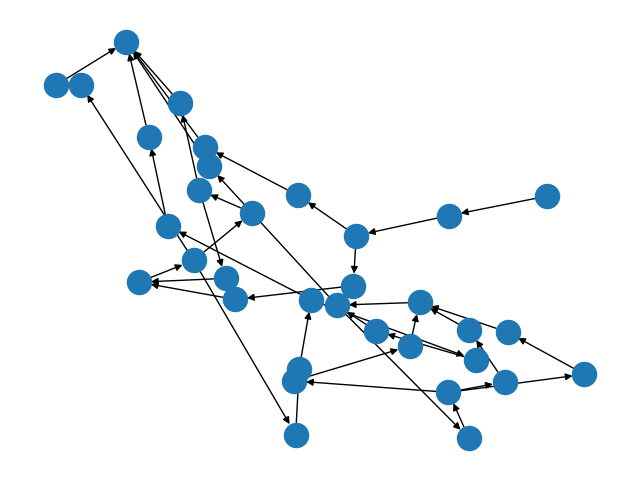

In [17]:
nx.draw(rg)

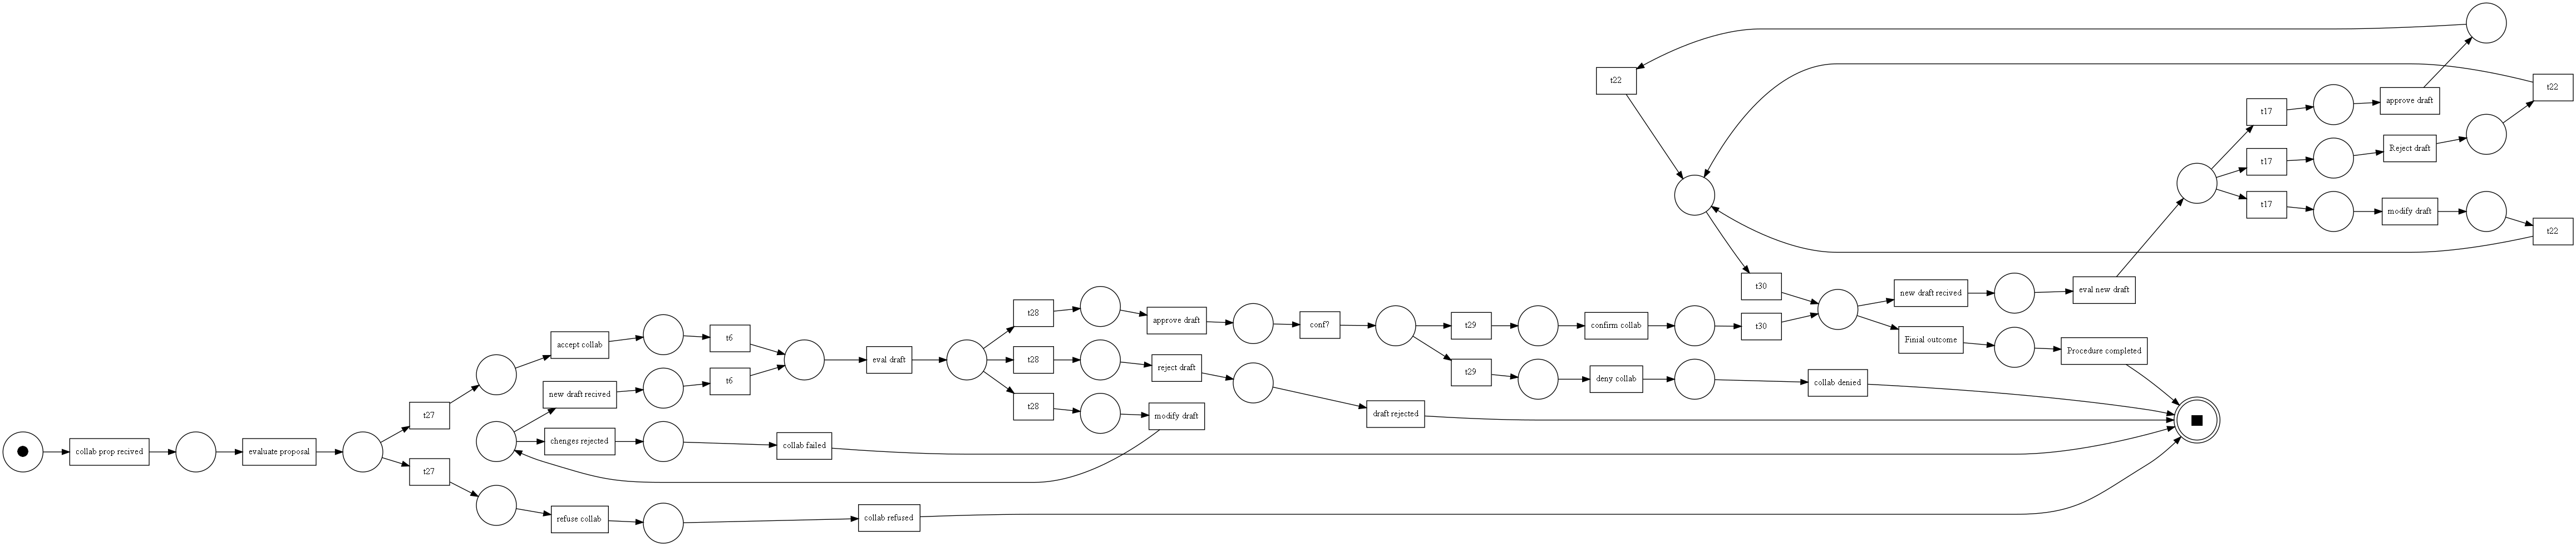

In [20]:
pm.view_petri_net(net, ip, fp)

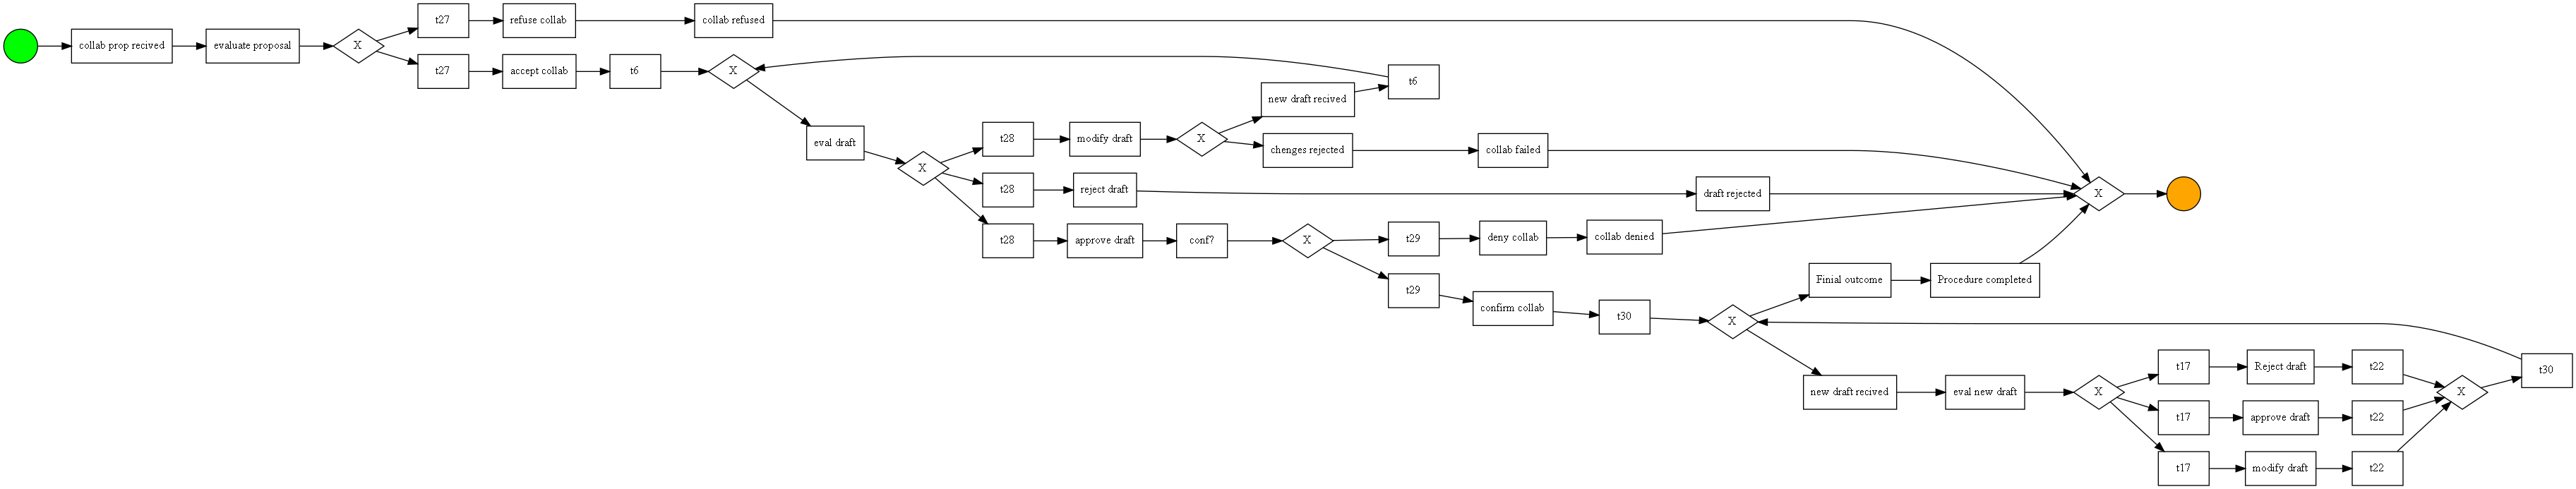

In [33]:
bpmn_diag = pm.convert_to_bpmn(net, ip, fp)
pm.view_bpmn(bpmn_diag)